In [599]:
from itertools import combinations, product

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtaidistance import dtw
from pyts.classification import KNeighborsClassifier, TimeSeriesForest
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split

### Генерация сигналов

In [3]:
def weierstrass_function(x: float | np.ndarray) -> float | np.ndarray:
    a, b = np.float64(3), np.float64(0.5)
    return sum(b ** n * np.cos(a ** n * np.pi * x) for n in range(100))

In [497]:
def signal_1(x: np.ndarray) -> np.ndarray:
    return weierstrass_function(x) * np.exp(- x * x) * np.sin(x + 0.4)


def signal_2(x: np.ndarray) -> np.ndarray:
    return np.abs(weierstrass_function(x / 6)) * \
        np.exp(- x * (x - 0.4) / 2) * np.sinh(x)


def signal_3(x: np.ndarray) -> np.ndarray:
    return 6 * np.arctan(weierstrass_function((x + 10) / 22)) * \
        np.sin((x + 0.2) * (x - 0.2)) * np.exp(-0.5 * x * x) * np.cosh(x - 0.2)

In [607]:
DURATION = 4  # сек
NUM_SAMPLES = 1000
x = np.linspace(-DURATION, DURATION, NUM_SAMPLES) * 1.2

In [532]:
SIGNALS = np.array([
    [
        signal_1(x + 2),
        signal_1(x * 0.7),
        signal_1(x * 0.4),
        signal_1((x + 1.5) * 0.8),
        signal_1((x - 1.5) * 1.5),
        signal_1((x - 1.5) * 0.4),
        signal_1((x + 1.5) * 0.5),
    ],
    [
        signal_2(x - 2),
        signal_2(x * 1.5),
        signal_2(x * 0.5),
        signal_2(x + 1.5),
        signal_2((x - 1) * 0.8),
        signal_2((x - 0.6) * 1.5),
        signal_2((x + 0.6) * 0.5),
    ],
    [
        signal_3(x),
        signal_3(x * 1.5),
        signal_3(x * 0.7),
        signal_3(x + 0.3),
        signal_3(x - 0.3),
        signal_3((x - 0.3) * 1.5),
        signal_3((x + 0.3) * 0.7),
    ],
])

In [238]:
def visualize_plot(x: np.ndarray, y: list[np.ndarray]) -> None: 
    cols_num = len(y)
    nrows = int(np.ceil(np.sqrt(cols_num))) 
    ncols = int(np.ceil(cols_num / nrows)) 
 
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20)) 
    for ax, column in zip(axes.reshape(-1), y): 
        ax.plot(x + DURATION, column) 

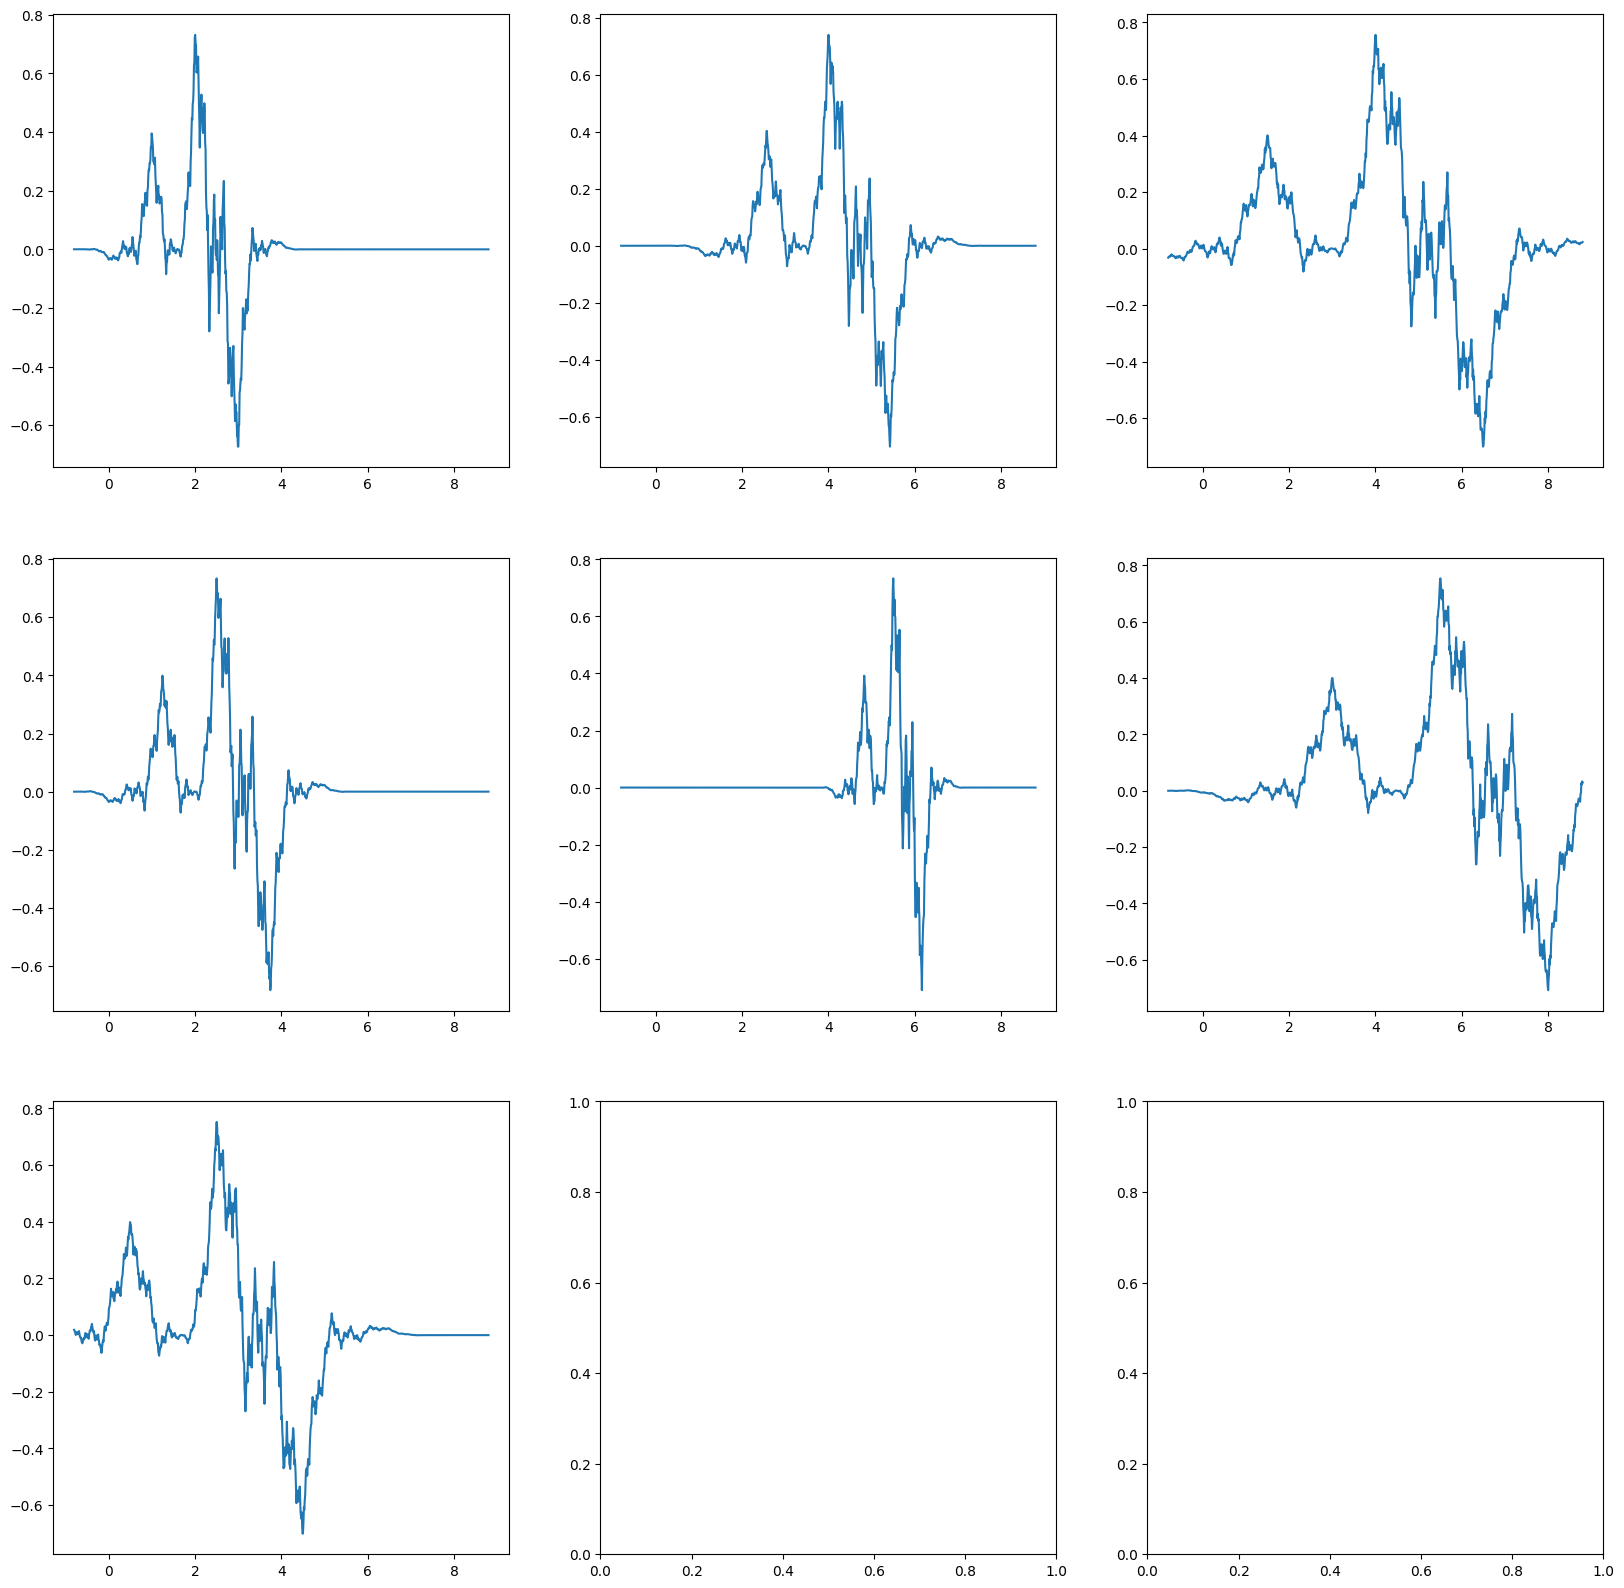

In [525]:
visualize_plot(x, SIGNALS[0])

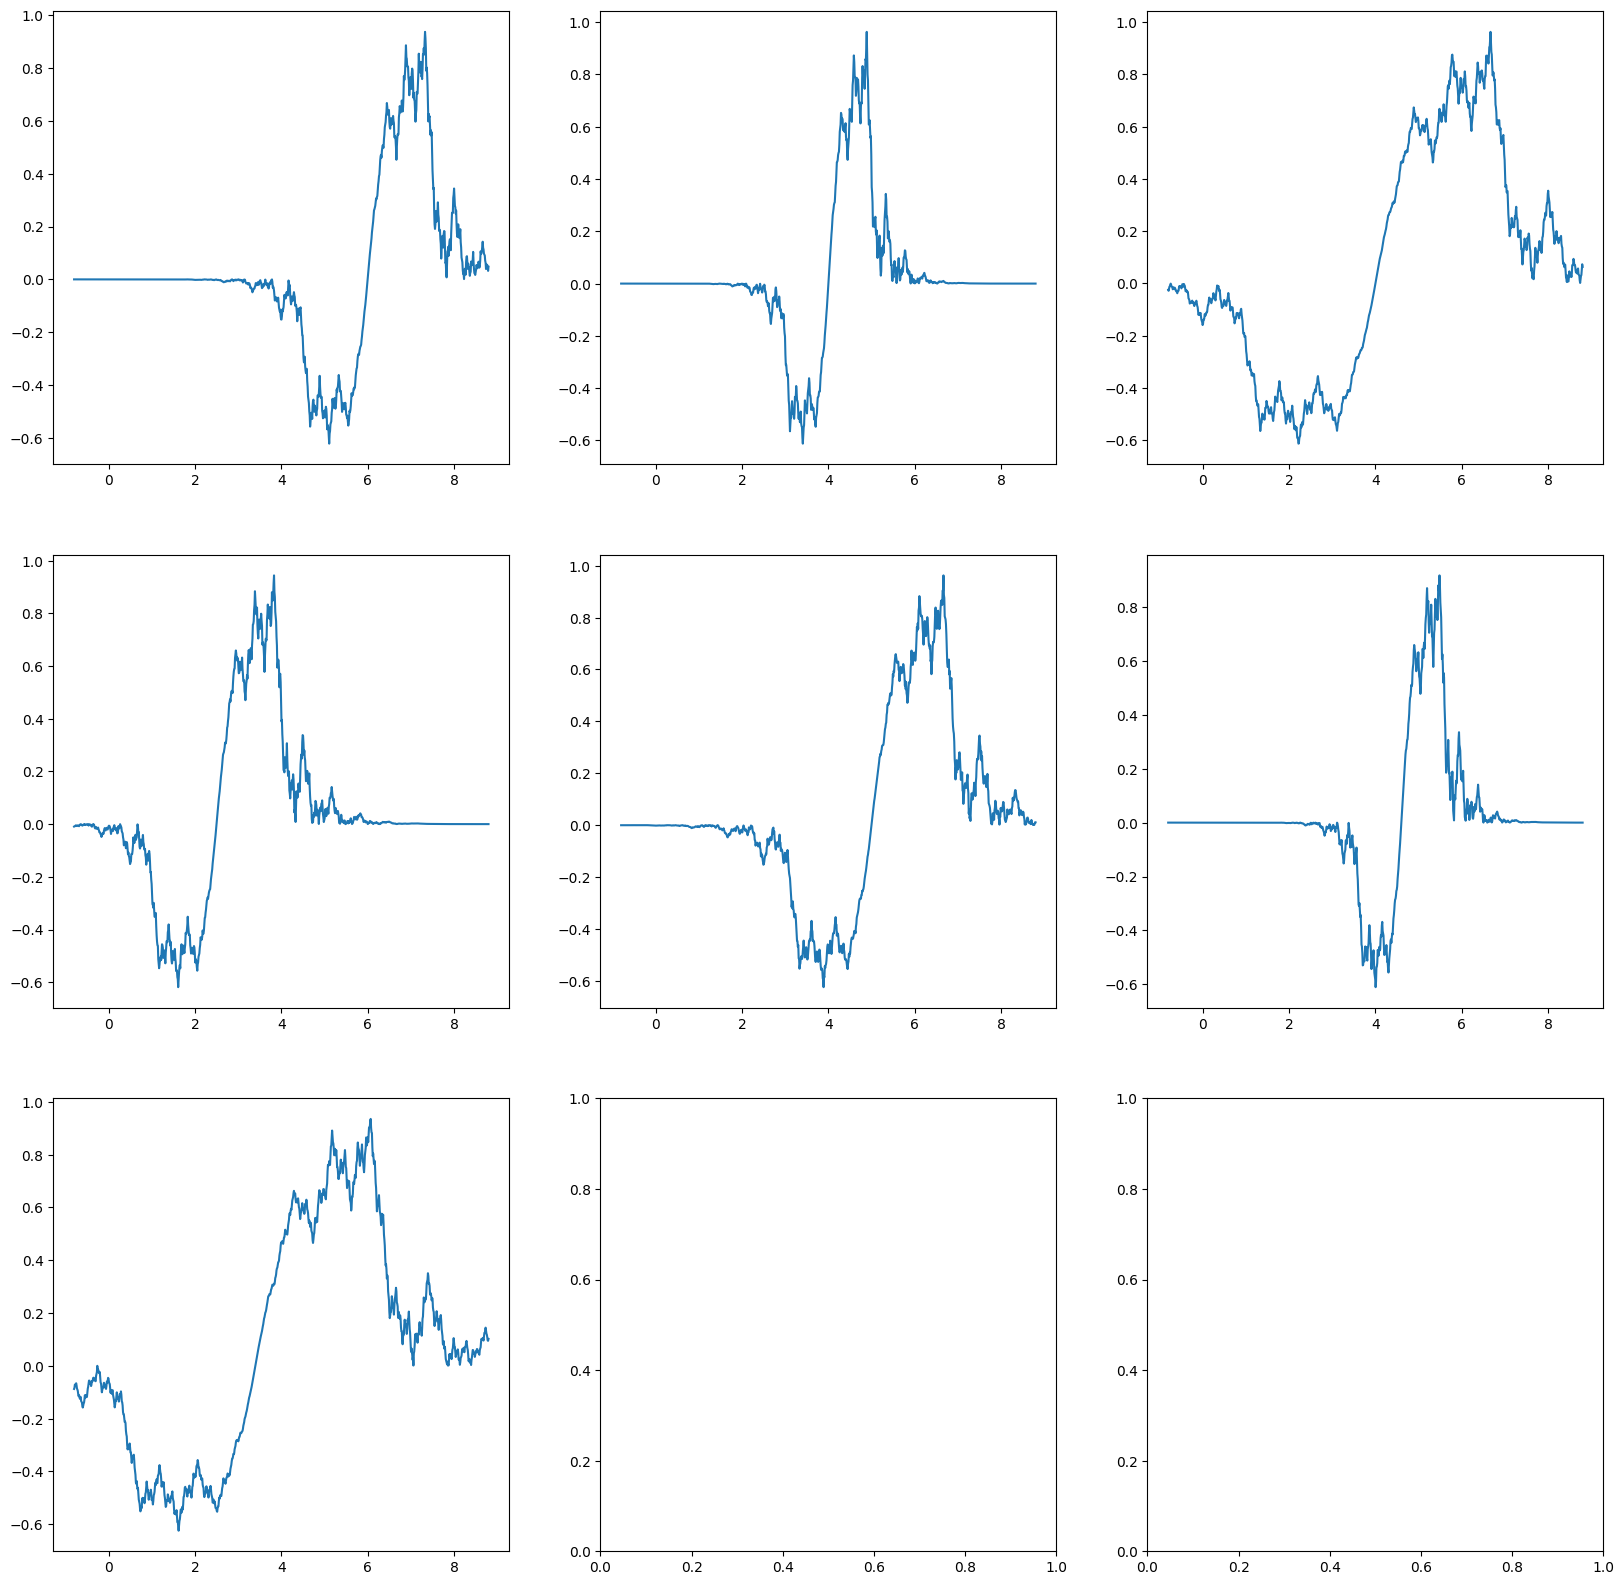

In [533]:
visualize_plot(x, SIGNALS[1])

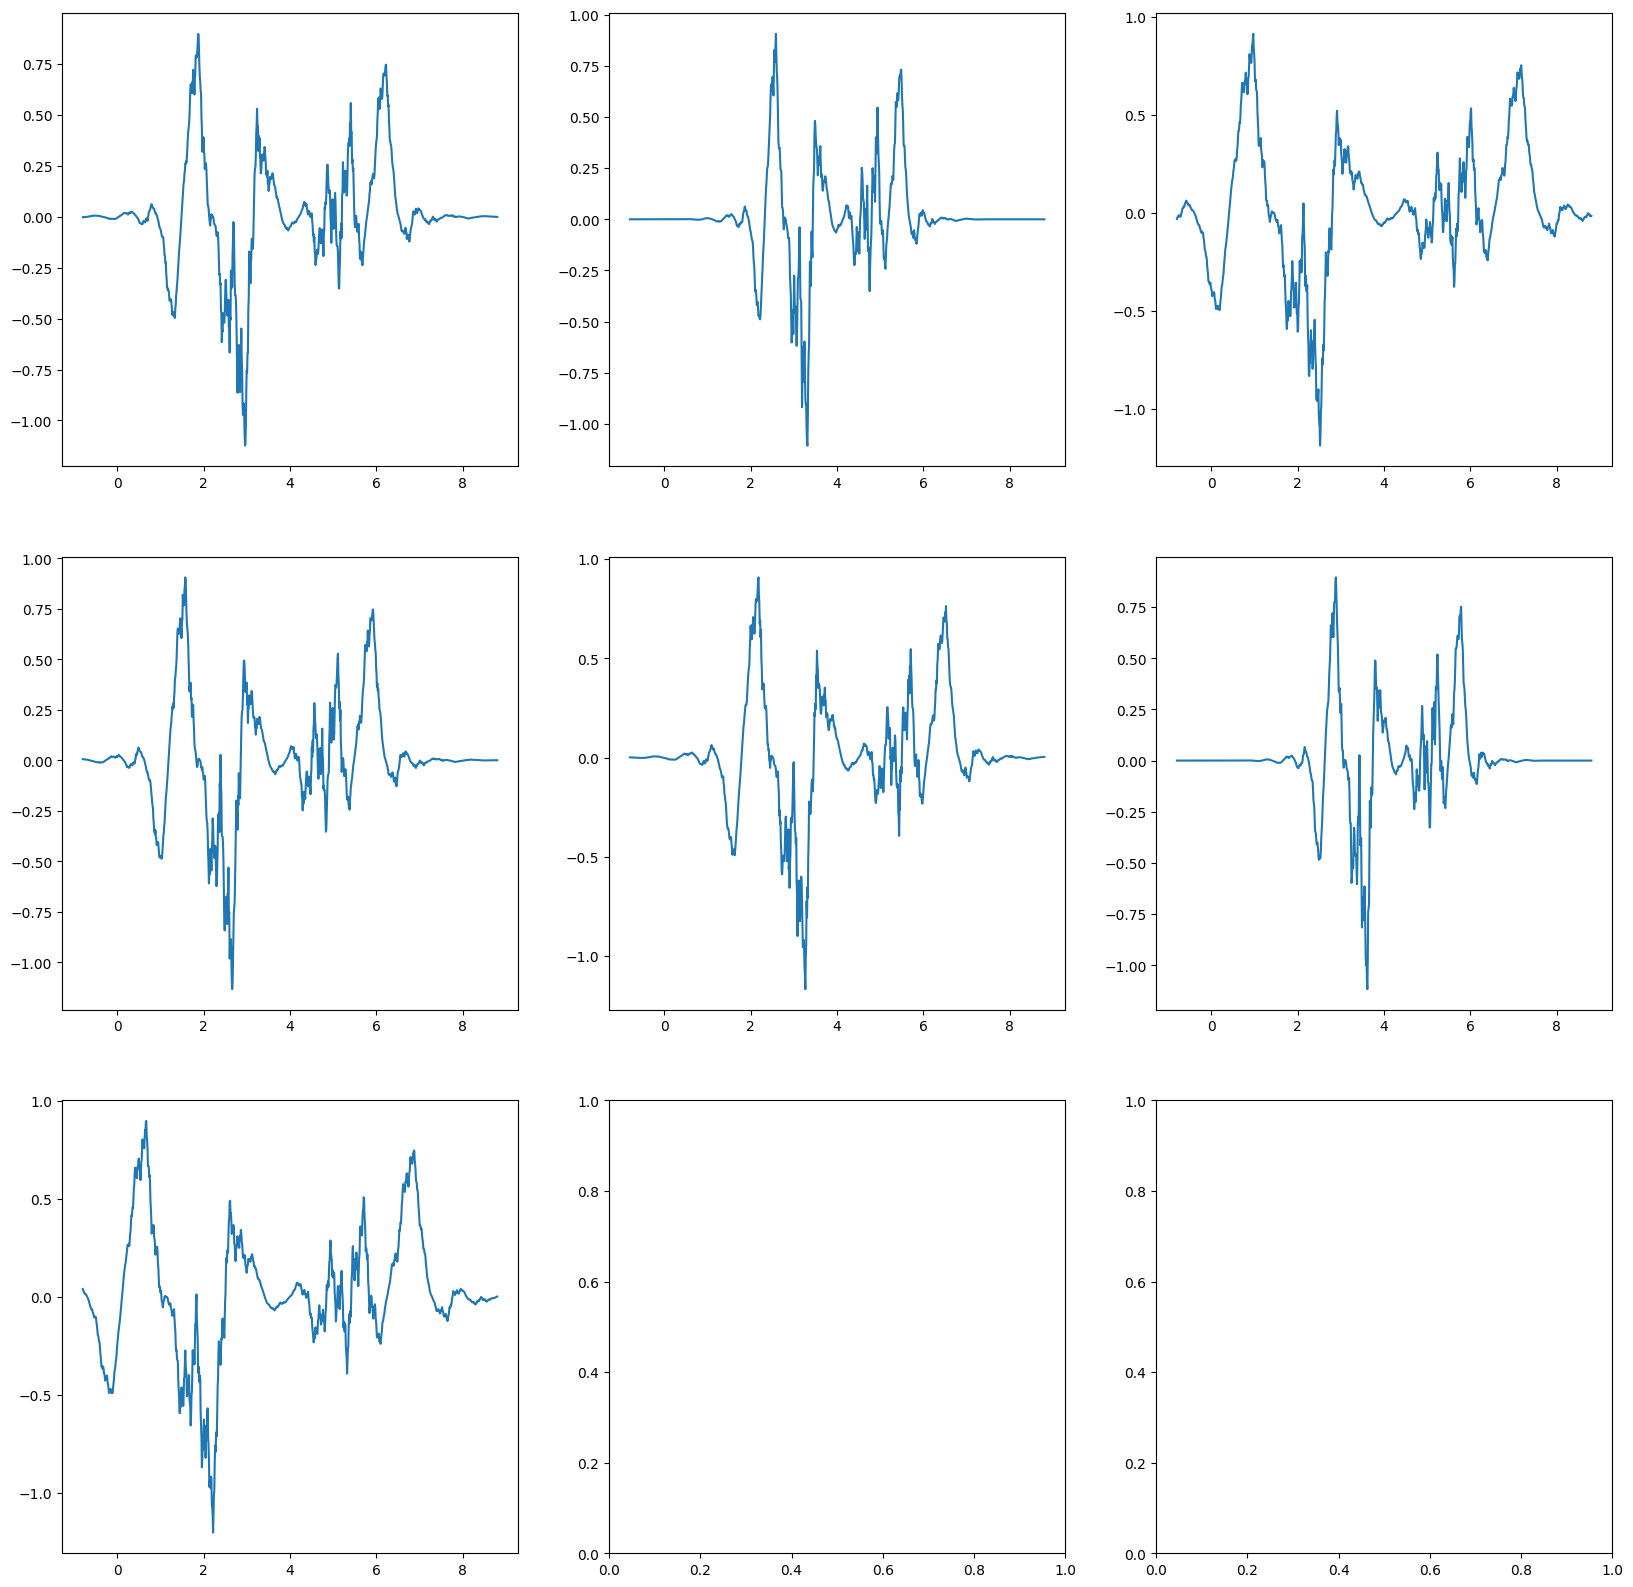

In [508]:
visualize_plot(x, SIGNALS[2])

### Евклидовы расстояния

In [534]:
euclidean_dist = [[0] * 21 for _ in range(21)]

for i in range(3):
    for s1, s2 in combinations(range(7), 2):
        distance = euclidean(SIGNALS[i][s1], SIGNALS[i][s2])
        euclidean_dist[i * 7 + s1][i * 7 + s2] = euclidean_dist[i * 7 + s2][i * 7 + s1] = distance
        print(f"Евклидово расстояние между SIGNALS_{i}{s1} и SIGNALS_{i}{s2}:", distance)
    print()

for t1, t2 in combinations(range(3), 2):
    for s1, s2 in product(range(7), range(7)):
        distance = euclidean(SIGNALS[t1][s1], SIGNALS[t2][s2])
        euclidean_dist[t1 * 7 + s1][t2 * 7 + s2] = euclidean_dist[t2 * 7 + s2][t1 * 7 + s1] = distance
        print(f"Евклидово расстояние между SIGNALS_{t1}{s1} и SIGNALS_{t2}{s2}:", distance)
    print()

Евклидово расстояние между SIGNALS_00 и SIGNALS_01: 7.646942484886605
Евклидово расстояние между SIGNALS_00 и SIGNALS_02: 8.4607405319349
Евклидово расстояние между SIGNALS_00 и SIGNALS_03: 7.123850488035204
Евклидово расстояние между SIGNALS_00 и SIGNALS_04: 6.229146554016933
Евклидово расстояние между SIGNALS_00 и SIGNALS_05: 9.752365404269149
Евклидово расстояние между SIGNALS_00 и SIGNALS_06: 8.6461905365553
Евклидово расстояние между SIGNALS_01 и SIGNALS_02: 7.756147032342228
Евклидово расстояние между SIGNALS_01 и SIGNALS_03: 7.716747706647648
Евклидово расстояние между SIGNALS_01 и SIGNALS_04: 7.82082805588375
Евклидово расстояние между SIGNALS_01 и SIGNALS_05: 10.672505205598174
Евклидово расстояние между SIGNALS_01 и SIGNALS_06: 8.872384492971687
Евклидово расстояние между SIGNALS_02 и SIGNALS_03: 9.87024000746698
Евклидово расстояние между SIGNALS_02 и SIGNALS_04: 7.980129175198309
Евклидово расстояние между SIGNALS_02 и SIGNALS_05: 11.102063419436181
Евклидово расстояние меж

### DTW

In [536]:
import torch
dtw_dist = [[0] * 21 for _ in range(21)]

for i in range(3):
    for s1, s2 in combinations(range(7), 2):
        distance = dtw.distance(SIGNALS[i][s1], SIGNALS[i][s2])
        dtw_dist[i * 7 + s1][i * 7 + s2] = dtw_dist[i * 7 + s2][i * 7 + s1] = distance
        print(f"DTW расстояние между SIGNALS_{i}{s1} и SIGNALS_{i}{s2}:", distance)
    print()
    torch.save(dtw_dist, 'dtw_dist')

for t1, t2 in combinations(range(3), 2):
    for s1, s2 in product(range(7), range(7)):
        distance = dtw.distance(SIGNALS[t1][s1], SIGNALS[t2][s2])
        dtw_dist[t1 * 7 + s1][t2 * 7 + s2] = dtw_dist[t2 * 7 + s2][t1 * 7 + s1] = distance
        print(f"DTW расстояние между SIGNALS_{t1}{s1} и SIGNALS_{t2}{s2}:", distance)
    print()
    torch.save(dtw_dist, 'dtw_dist')

DTW расстояние между SIGNALS_00 и SIGNALS_01: 0.32525926256581966
DTW расстояние между SIGNALS_00 и SIGNALS_02: 0.4761373761951579
DTW расстояние между SIGNALS_00 и SIGNALS_03: 0.3099848937081689
DTW расстояние между SIGNALS_00 и SIGNALS_04: 0.35988245533308755
DTW расстояние между SIGNALS_00 и SIGNALS_05: 0.4963779577645179
DTW расстояние между SIGNALS_00 и SIGNALS_06: 0.39721434915003007
DTW расстояние между SIGNALS_01 и SIGNALS_02: 0.42069504951349135
DTW расстояние между SIGNALS_01 и SIGNALS_03: 0.2905697869563753
DTW расстояние между SIGNALS_01 и SIGNALS_04: 0.4137969135791804
DTW расстояние между SIGNALS_01 и SIGNALS_05: 0.4373257926363259
DTW расстояние между SIGNALS_01 и SIGNALS_06: 0.296758586323607
DTW расстояние между SIGNALS_02 и SIGNALS_03: 0.429128538703698
DTW расстояние между SIGNALS_02 и SIGNALS_04: 0.5881755410016091
DTW расстояние между SIGNALS_02 и SIGNALS_05: 0.36111375692213527
DTW расстояние между SIGNALS_02 и SIGNALS_06: 0.3575674115114684
DTW расстояние между S

### Анализ расстояний (визуализация через матрицу расстояний)

In [352]:
def visualize_dist(data: list[list]) -> None:
    fig, ax = plt.subplots(figsize=(18, 15))
    sns.heatmap(data, annot=data, ax=ax)
    plt.show()

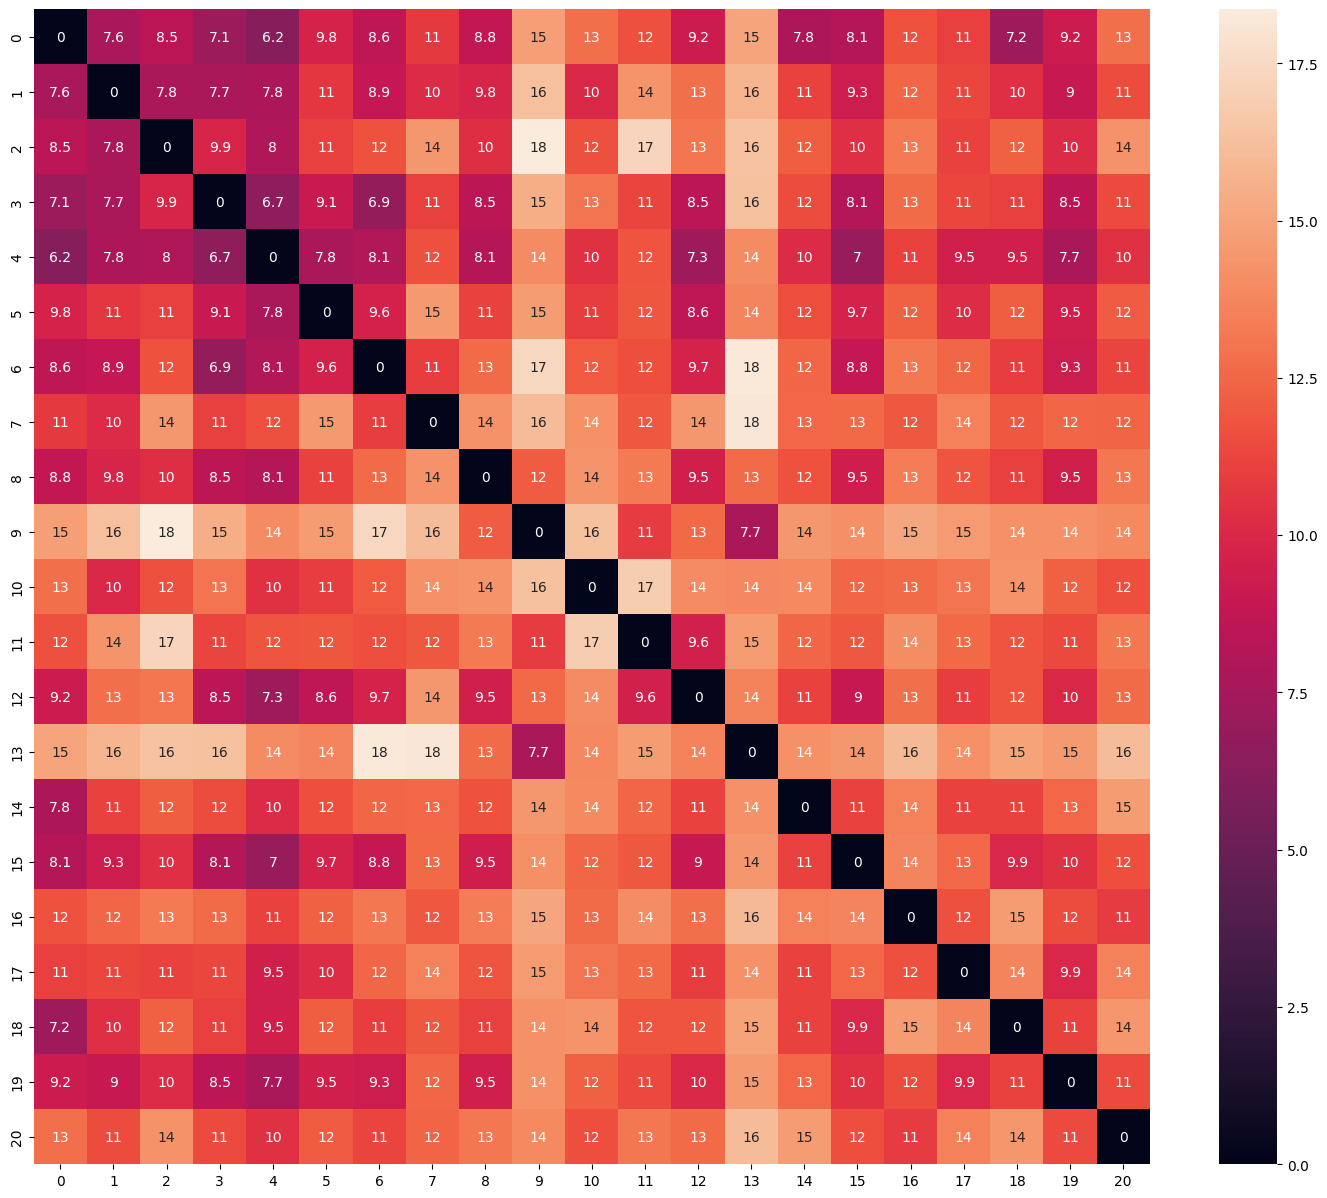

In [535]:
# Как видно, евклидово расстояние не даёт возможности отделить один класс от другого
visualize_dist(np.array(euclidean_dist))

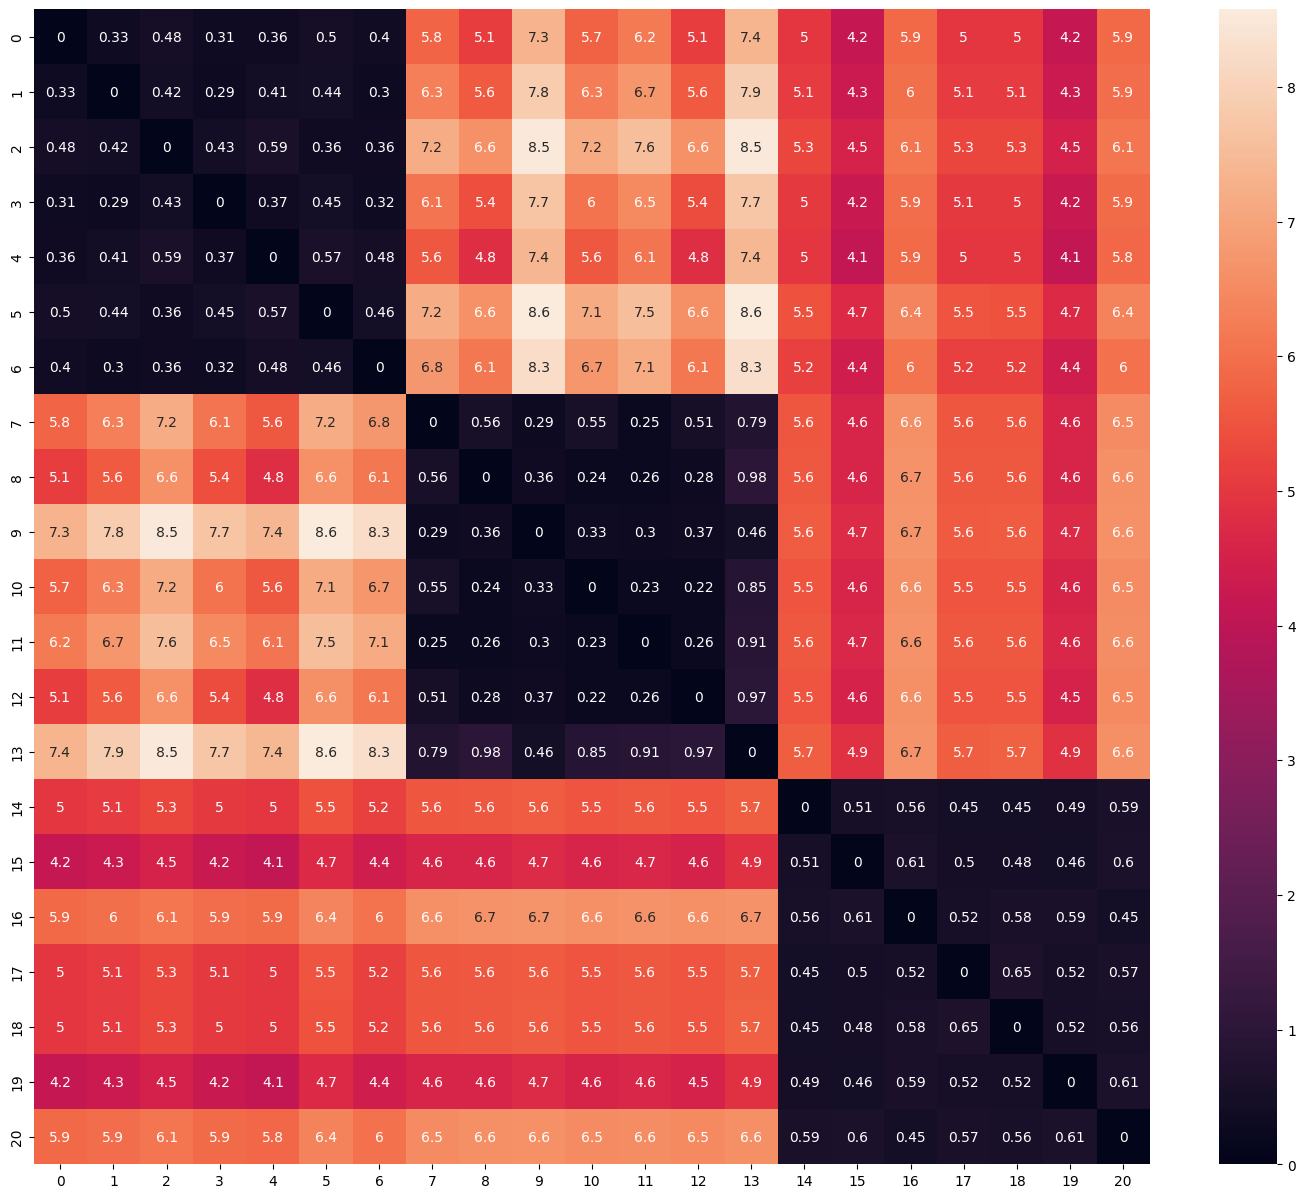

In [537]:
#  DTW же показывает чёткое различие между классами
visualize_dist(np.array(dtw_dist))
plt.show()

Как мы видим из матриц расстояний, евклидова метрика не даёт чёткой разницы между классами в отличие от DTW

### Classification

In [594]:
values = np.array(SIGNALS).reshape(-1, len(x))
target_feature = np.array([0] * 7 + [1] * 7 + [2] * 7)
train_x, test_x, train_y, test_y = train_test_split(values, target_feature, test_size=5)

#### KNN classification

In [597]:
# Евклидово расстояние
clf = KNeighborsClassifier(p=2)
clf.fit(train_x, train_y)

print(f"Accuracy {clf.score(test_x, test_y)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(test_x[0].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {test_y[0]}")

Accuracy 0.4
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 1


In [598]:
# DTW
clf = KNeighborsClassifier(metric='dtw')
clf.fit(train_x, train_y)

print(f"Accuracy {clf.score(test_x, test_y)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(test_x[0].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {test_y[0]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1


#### TimeSeriesForest

In [606]:
clf = TimeSeriesForest(random_state=55)
clf.fit(train_x, train_y)

print(f"Accuracy {clf.score(test_x, test_y)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(test_x[0].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {test_y[0]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.324 0.342 0.334]]
Истинный класс для предсказаний 1


KNN с DTW работает гораздо лучше, чем со стандартной метрикой
TimeSeriesForest также правильно классифицирует, но для некоторых сэмплов вероятности для всех классов очень близки